In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
path = "/content/drive/My Drive/CSC2503-Project"
os.chdir(path)

Mounted at /content/drive


In [2]:
import torch
import timm
from torch.utils.data import DataLoader
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from torchvision import transforms
import torch.nn as nn

from ouhands_loader import OuhandsDS

dino_model_name = 'vit_small_patch16_dinov3'
model = timm.create_model(
    dino_model_name,
    pretrained=True,
)

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

batch_size = 32
num_workers = 4
use_bbox = False

train_ds = OuhandsDS(split='train',
                     transform=transform,
                     use_bounding_box=use_bbox,
                     crop_to_bbox=use_bbox)
val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=use_bbox,
                   crop_to_bbox=use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=use_bbox,
                    crop_to_bbox=use_bbox)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True
                          ,  num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False
                        , num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False
                          , num_workers=num_workers, pin_memory=True)

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.4M [00:00<?, ?B/s]

Loaded 1600 samples for train split
Class distribution: {'A': 160, 'B': 160, 'C': 160, 'D': 160, 'E': 160, 'F': 160, 'H': 160, 'I': 160, 'J': 160, 'K': 160}
Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Using device: cuda


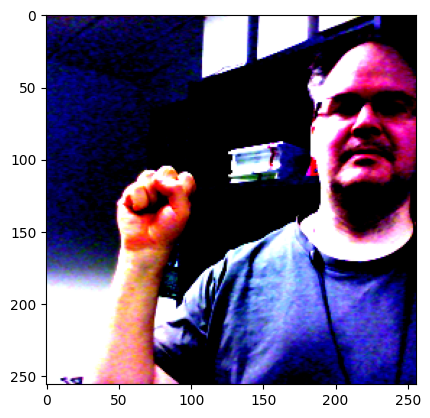

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_ds[0][0].permute(1, 2, 0).numpy())

In [4]:
import copy
import torch
import torch.nn as nn
import timm

dino_model_name = 'vit_small_patch16_dinov3'
num_classes = 10

backbone = timm.create_model(
    dino_model_name,
    pretrained=True,
    num_classes=0,
)

extra_block = copy.deepcopy(backbone.blocks[-1])
head = nn.Linear(backbone.embed_dim, num_classes)

class DinoWithExtraBlock(nn.Module):
  def __init__(self, backbone, extra_block, head):
      super().__init__()
      self.backbone = backbone
      self.extra_block = extra_block
      self.head = head

      # Freeze all backbone params
      for p in self.backbone.parameters():
          p.requires_grad = False

      # Unfreeze the last 2 blocks
      for block in self.backbone.blocks[-1:]:
          for p in block.parameters():
              p.requires_grad = True

      # Extra_block + head are trainable
      for p in self.extra_block.parameters():
          p.requires_grad = True
      for p in self.head.parameters():
          p.requires_grad = True

  def forward(self, x):
      # Use the backbone's patch_embed and _pos_embed
      x = self.backbone.patch_embed(x)
      x = self.backbone._pos_embed(x)[0]  # This handles cls token and pos embeddings

      # Apply transformer blocks one by one
      for block in self.backbone.blocks:
          out = block(x)
          # Handle both tensor and tuple returns
          x = out[0] if isinstance(out, tuple) else out

      # Extra block
      out = self.extra_block(x)
      x = out[0] if isinstance(out, tuple) else out
      x = self.backbone.norm(x)

      # Extract cls token
      cls_token = x[:, 0]  # (B, C)

      # Linear probe head
      logits = self.head(cls_token)
      return logits

model = DinoWithExtraBlock(backbone, extra_block, head)
model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-4)
print("Total params:", sum(p.numel() for p in model.parameters()))
print("Trainable params:", sum(p.numel() for p in trainable_params))


Total params: 23364874
Trainable params: 3552010


In [ ]:
"""Utility functions"""
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import timm

import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score


# Optimizer / Scheduler
def param_groups(model, weight_decay=0.05):
    """ Add weight decay on non-bias or non-LayerNorm, BatchNorm weights"""
    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or n.endswith(".bias"):  # bias or LayerNorm/BatchNorm weights
            no_decay.append(p)
        else:
            decay.append(p)
    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]


# Training / Evaluation loops
def train_one_epoch(model, loader, optimizer, scaler, epoch, max_norm=1.0):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc=f"Train {epoch}", leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision training
        with autocast('cuda'):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        if max_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()

        preds = logits.argmax(1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=running_correct/total)

    return running_loss / total, running_correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with autocast('cuda'):
            logits = model(imgs)
            loss = criterion(logits, labels)
        preds = logits.argmax(1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, running_correct / total

def eval_on_test(model, test_loader):
  # Evaluation on the test set
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for imgs, labels in test_loader:
          imgs, labels = imgs.to(device), labels.to(device)
          logits = model(imgs)
          preds = logits.argmax(1)

          total_correct += (preds == labels).sum().item()
          total += imgs.size(0)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  accuracy = total_correct / total
  precision = precision_score(all_labels, all_preds, average='macro')
  recall = recall_score(all_labels, all_preds, average='macro')
  f1 = f1_score(all_labels, all_preds, average='macro')

  print(f"Test accuracy: {accuracy:.4f}")
  print(f"Precision (macro): {precision:.4f}")
  print(f"Recall (macro): {recall:.4f}")
  print(f"F1-score (macro): {f1:.4f}")

def visualize_attention_map(img, model):
  """Visualize attention map"""
  x = img.unsqueeze(0) # [1, 3, H, W]
  x = x.to(device)

  IMG_SIZE = x.shape[-1] # H = W
  patch = model.patch_embed.patch_size[0]

  # ---- Run through all but the last block; capture tokens pre-last-attn ----
  with torch.no_grad():
      # Patch embed + pos embed (+ optional pre-norm) like timm's forward_features
      x_tok = model.patch_embed(x)              # [B, Np, C]   (no cls yet)
      x_tok = model._pos_embed(x_tok)           # adds cls token & pos emb if present

      # Check if x_tok is a tuple and extract the tensor if it is
      if isinstance(x_tok, tuple):
          x_tok = x_tok[0]
      if hasattr(model, "pos_drop"):
          x_tok = model.pos_drop(x_tok)
      if hasattr(model, "norm_pre") and model.norm_pre is not None:
          x_tok = model.norm_pre(x_tok)

      # Forward through blocks except the last
      for blk in model.blocks[:-1]:
          x_tok = blk(x_tok)

      last_blk = model.blocks[-1]

      # ---- Compute attention of the last block explicitly ----
      # In a ViT block: y = x + Attn(LN1(x)), so the attention takes LN1(x) as input
      x_norm = last_blk.norm1(x_tok)

      # QKV projection
      B, N, C = x_norm.shape
      qkv = last_blk.attn.qkv(x_norm)  # [B, N, 3*C]
      num_heads = last_blk.attn.num_heads
      head_dim = C // num_heads
      scale = 1.0 / math.sqrt(head_dim)

      qkv = qkv.reshape(B, N, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)   # [3,B,H,N,D]
      q, k, v = qkv[0], qkv[1], qkv[2]                                         # each [B,H,N,D]

      attn = (q * scale) @ k.transpose(-2, -1)                                 # [B,H,N,N]
      attn = attn.softmax(dim=-1)                                              # prob over keys

      # ---- Reshape to patch grid and upsample to image size ----
      H_p = W_p = IMG_SIZE // patch                 # e.g., 32x32 for 512 input
      Np = H_p * W_p

      # ---- CLS-to-patches attention map (average over heads) ----
      # CLS token is at index 0; keep only patch tokens by slicing from (N - Np) onwards
      attn_cls = attn[:, :, 0, (N - Np):]                                      # [B, H, Np]
      attn_map = attn_cls.max(1).values

      # robust: patches are the *last* Np tokens in the sequence
      attn_map = attn_map.reshape(B, 1, H_p, W_p) # [B,1,H_p,W_p]
      attn_map = F.interpolate(attn_map, size=(IMG_SIZE, IMG_SIZE), mode="bicubic", align_corners=False)
      attn_map = attn_map[0,0] # [H, W]
      # Normalize for visualization
      attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-6)

  # ---- Plot overlay ----
  plt.figure(figsize=(8,8))
  img_np = x[0].cpu().permute(1, 2, 0).numpy()
  plt.imshow(img_np)
  plt.imshow(attn_map.cpu(), cmap='jet', alpha=0.6)
  plt.axis('off')
  plt.tight_layout()
  plt.show()



In [ ]:
"""DINO with extra block - training"""

model = DinoWithExtraBlock(backbone, extra_block, head)
model = model.to(device)

lr = 5e-4
optimizer = AdamW(param_groups(model), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

# LR scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Gradient Scaling
scaler = GradScaler()

# Training
epochs = 20
best_acc = 0.0
best_state = None
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, epoch)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

if best_state is not None:
  best_name = f"{dino_model_name}_with_extra_attention_best.pt"
  torch.save(best_state, f"./checkpoints/{best_name}")
  print(f"Saved best model with val_acc={best_acc:.4f} to {best_name}")

# load best model
model = DinoWithExtraBlock(backbone, extra_block, head)
model.load_state_dict(best_state)
model = model.to(device)
eval_on_test(model, test_loader)

# Flop & model size
from thop import profile
dummy_input = next(iter(test_loader))[0]
dummy_input = dummy_input.to(device)
flops, params = profile(model, inputs=(dummy_input,))

print(f"FLOPs: {flops / 1e9:.2f}G")
print(f"Params: {params / 1e6:.2f}M")
visualize_attention_map(train_ds[0][0], model)


Epoch 01: train_loss=1.9744 train_acc=0.2819 | val_loss=1.5868 val_acc=0.4175


Epoch 02: train_loss=1.0158 train_acc=0.6562 | val_loss=1.2091 val_acc=0.5375


Epoch 03: train_loss=0.5706 train_acc=0.8156 | val_loss=1.1276 val_acc=0.5900


Epoch 04: train_loss=0.3113 train_acc=0.9038 | val_loss=1.2521 val_acc=0.6200


Epoch 05: train_loss=0.2220 train_acc=0.9313 | val_loss=1.2815 val_acc=0.5850


Epoch 06: train_loss=0.1091 train_acc=0.9738 | val_loss=1.1627 val_acc=0.6175


Epoch 07: train_loss=0.0569 train_acc=0.9875 | val_loss=1.2688 val_acc=0.6300


Epoch 08: train_loss=0.0278 train_acc=0.9962 | val_loss=1.3874 val_acc=0.6500


Epoch 09: train_loss=0.0220 train_acc=0.9931 | val_loss=1.5973 val_acc=0.5975


Epoch 10: train_loss=0.0121 train_acc=0.9988 | val_loss=1.5866 val_acc=0.6150


Epoch 11: train_loss=0.0038 train_acc=1.0000 | val_loss=1.5756 val_acc=0.6175


Epoch 12: train_loss=0.0030 train_acc=1.0000 | val_loss=1.5888 val_acc=0.6100


Epoch 13: train_loss=0.0026 train_acc=1.0000 | val_loss=1.5903 val_acc=0.6100


Epoch 14: train_loss=0.0024 train_acc=1.0000 | val_loss=1.6002 val_acc=0.6100


Epoch 15: train_loss=0.0022 train_acc=1.0000 | val_loss=1.6029 val_acc=0.6125


Epoch 16: train_loss=0.0021 train_acc=1.0000 | val_loss=1.6045 val_acc=0.6125


Epoch 17: train_loss=0.0020 train_acc=1.0000 | val_loss=1.6083 val_acc=0.6125


Epoch 18: train_loss=0.0020 train_acc=1.0000 | val_loss=1.6095 val_acc=0.6150


Epoch 19: train_loss=0.0020 train_acc=1.0000 | val_loss=1.6102 val_acc=0.6150


Epoch 20: train_loss=0.0020 train_acc=1.0000 | val_loss=1.6102 val_acc=0.6150
Saved best model with val_acc=0.6500 to vit_small_patch16_dinov3_with_extra_attention_best.pt.pt
